# Stage 1. IR description - Turkey 3-month Bond Yield

**Made by** Vadim Smirnov and Vladislav Gusev

------------------------------

## Introduction:

Due to the unacessablility of the key interest rates in Turkey it was decided to replicate this indicator with the market rate. 10-year bonds in many countries could be considered representative on the current state of the economy, as well as forward-looking. Usually the 1-year yield is considered, but the 2-year is still pretty accurate in terms of the estimation of the short-term yield.

Due to the extreme inversion of the yield curve currently (10year - 2year spread is -1655 bp) and it is humped-shaped as the yields between 3 and 9 months are relatively lower to the 2-year yield. 

**Quoting and conventions:**

Day count basis: ACT/360 or 30E/360

Settlement, primary and secondary market (for International bonds as a benchmark): T+2

Coupon rate: 12.6%, semi-annual

**Those conventions are common for the majority of the European countries with the exception that usually bonds have annual coupons**

## Primary Analysis:

In [1]:
#!pip install tslearn
#!pip install threadpoolctl --upgrade
#!pip install numpy --upgrade
#!pip install --upgrade scikit-learn

In [302]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns
from sklearn.metrics import silhouette_score

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.api import AutoReg
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [442]:
df = pd.read_csv("turk3myield.csv")
df["Date"] =pd.to_datetime(df["Date"])
df["Price"] = df["Price"] * 0.01
df = df.sort_values(by='Date')
df.index = df["Date"]
X = df['Price'].values.reshape(-1,1)
df.head()

,Date,Price,Open,High,Low,Change %
Date,,,,,,
2000-01-05,2000-01-05,0.4071,40.71,40.71,40.71,-21.92%
2000-01-19,2000-01-19,0.3301,33.01,33.01,33.01,-18.91%
2000-01-20,2000-01-20,0.3365,33.65,33.65,33.65,1.94%
2000-01-21,2000-01-21,0.3358,33.58,33.58,33.58,-0.21%
2000-01-24,2000-01-24,0.3367,33.67,33.67,33.67,0.27%


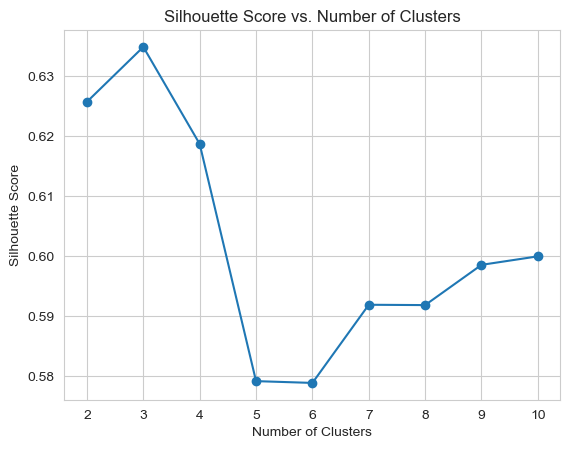

In [443]:
min_clusters = 2
max_clusters = 10
cluster_range = range(min_clusters, max_clusters + 1)

# Calculate silhouette scores for different numbers of clusters
silhouette_scores = []
for n_clusters in cluster_range:
    # Fit K-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(X)
    
    # Calculate silhouette score
    silhouette_avg = silhouette_score(X, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot silhouette scores vs. number of clusters
import matplotlib.pyplot as plt

plt.plot(cluster_range, silhouette_scores, marker='o')
plt.title('Silhouette Score vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.xticks(cluster_range)
plt.grid(True)
plt.show()

**Choosing 3 clusters with the best score**

In [444]:
# Clustering (using K-means)
n_clusters = 3  # Number of clusters
kmeans = KMeans(n_clusters=n_clusters)
cluster_labels = kmeans.fit_predict(X.reshape(-1,1))

# Print cluster centers and labels
print("Cluster Centers:")
print(kmeans.cluster_centers_)
print("Cluster Labels:")
print(cluster_labels)

Cluster Centers:
[[0.36988419]
 [0.09249344]
 [0.17846592]]
Cluster Labels:
[0 0 0 ... 0 0 0]


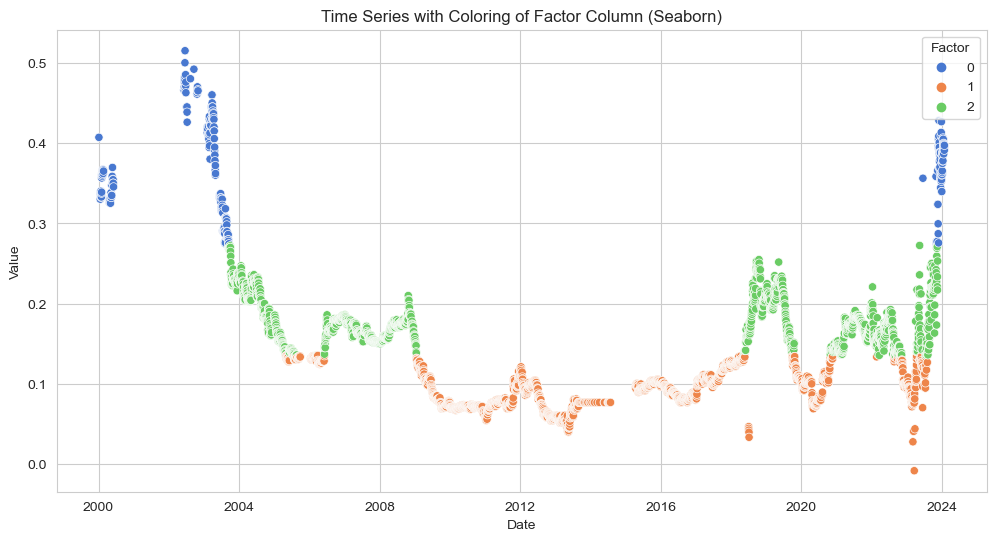

In [445]:
df['Cluster'] = cluster_labels

sns.set_style("whitegrid")

# Plot time series with coloring based on the 'factor' column using seaborn
plt.figure(figsize=(12, 6))
sns.scatterplot(x='Date', y='Price', hue='Cluster', data=df, palette='muted')
plt.title('Time Series with Coloring of Factor Column (Seaborn)')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend(title='Factor')
plt.show()

## Qualitative Conclusions:

There were sevelral critical periods in Turkish economy, namely global economic crisis - its beginning and the aftermath; period between 2018 and 2019 - economic crisis; economic instability in 2021-2022 due to Ukranian crisis and the most recent rise in short term interst rates as the govenment tries to fight the neverending inflation.

Turkish economy is one of the most interesting relatively developed countries with massive market return volatility.

# Stage 2. IR Modelling - Turkey 3-month Bond Yield

#### Working with AR

In [446]:
for i in range(1, 4):
    df[f'Lag_{i}'] = df['Price'].shift(i)

In [447]:
train_size = int(0.8 * len(df))
train_df = df[:train_size]
test_df = df[train_size:]
train_y = train_df['Price']
test_y = test_df['Price']

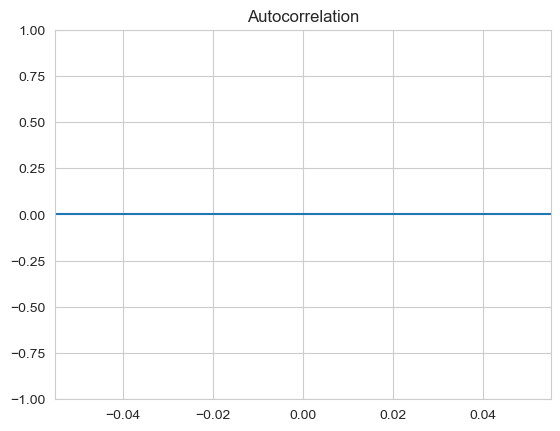

In [448]:
series = df['Price'] - df['Lag_1']
plot_acf(series)
plt.show()

In [449]:
ar_model = AutoReg(train_y, lags=1)
ar_results = ar_model.fit()

  
y_pred = ar_results.predict(start=len(train_df), end=len(train_df) + len(test_df) - 1, dynamic=False)
 
# Calculate MAE and RMSE
mae = mean_absolute_error(test_y, y_pred)
rmse = np.sqrt(mean_squared_error(test_y, y_pred))
print(f'Mean Absolute Error: {mae:.2f}')
print(f'Root Mean Squared Error: {rmse:.2f}')

Mean Absolute Error: 0.05
Root Mean Squared Error: 0.08


C:\Users\dguse\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\dguse\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\dguse\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\dguse\anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will co

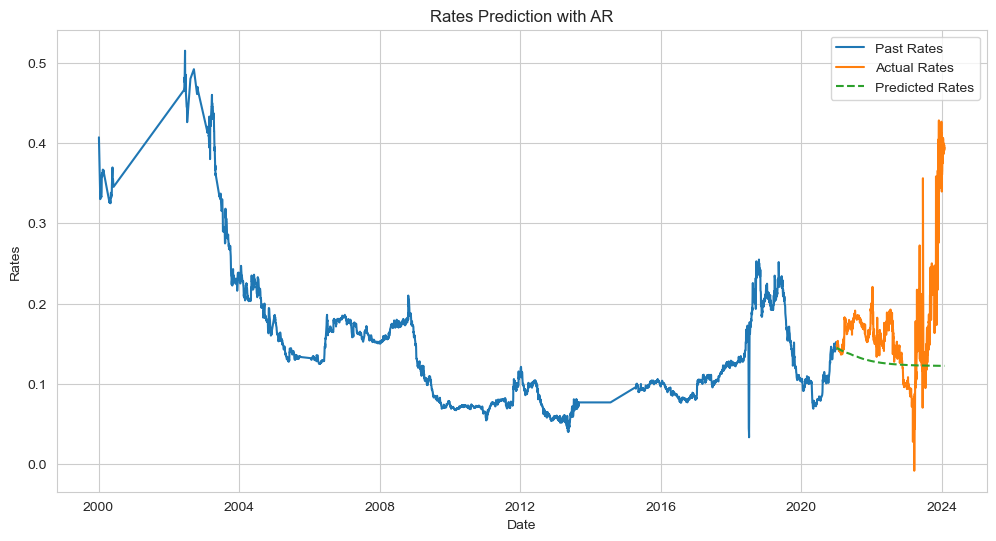

In [450]:
# Visualize the results
plt.figure(figsize=(12, 6))
plt.plot(train_df.index,train_y, label='Past Rates')
plt.plot(test_df.index,test_y, label='Actual Rates')
plt.plot(test_df.index,y_pred, label='Predicted Rates', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Rates')
plt.legend()
plt.title('Rates Prediction with AR')
plt.show()

In [451]:
lamb_test = (1- ar_results.params.iloc[1]) / (1/252)
mu_test = ar_results.params.iloc[0]/(1- ar_results.params.iloc[1])

C:\Users\dguse\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\dguse\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\dguse\anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


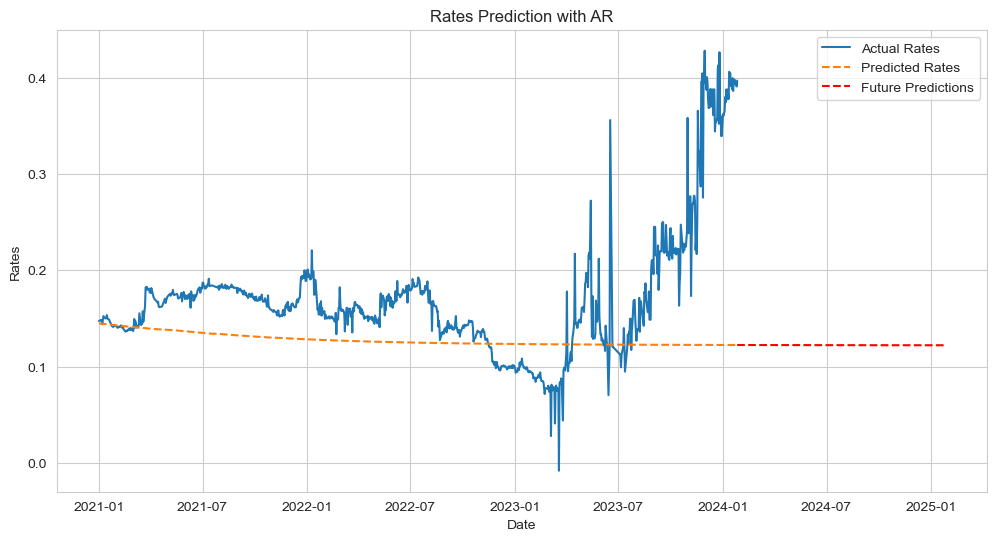

In [452]:
forecast_steps = 365
 
# Extend the predictions into the future for one year
future_indices = range(len(test_df), len(test_df) + forecast_steps)
future_predictions = ar_results.predict(start=len(train_df), end=len(train_df) + len(test_df) + forecast_steps - 1, dynamic=True)
 
# Create date indices for the future predictions
future_dates = pd.date_range(start=test_df['Date'].iloc[-1], periods=forecast_steps, freq='D')
 
# Plot the actual data, existing predictions, and one year of future predictions
plt.figure(figsize=(12, 6))
plt.plot(test_df['Date'], test_y, label='Actual Rates')
plt.plot(test_df['Date'], y_pred, label='Predicted Rates', linestyle='--')
plt.plot(future_dates, future_predictions[-forecast_steps:], label='Future Predictions', linestyle='--', color='red')
plt.xlabel('Date')
plt.ylabel('Rates')
plt.legend()
plt.title('Rates Prediction with AR')
plt.show()

In [453]:
ar_results.params

const       0.000521
Price.L1    0.995729
dtype: float64

### Construction of Vasicek model

In [454]:
from scipy.optimize import fmin
import matplotlib.markers as mk
import matplotlib.ticker as mtick

As the data we analyze is daily, the variable delta t is equal to 1 

In [455]:
lamb = (1- ar_results.params.iloc[1]) / (1/252)
mu = ar_results.params.iloc[0]/(1- ar_results.params.iloc[1])

#### Collecting data on the yield curve from the webiste http://www.worldgovernmentbonds.com/country/turkey/

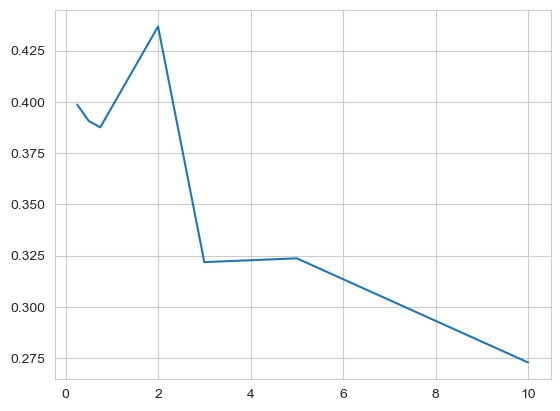

In [456]:
termstruc = pd.DataFrame()
termstruc['Maturity'] = [3/12, 6/12, 9/12, 2, 3, 5, 10]
termstruc['Yield'] = np.array([39.866, 39.068, 38.755, 43.675, 32.180, 32.365, 27.285])*0.01
plt.plot(termstruc["Maturity"], termstruc['Yield'])
None

#### Interpolating using NSS algorithm

In [457]:
b = pd.DataFrame({"Maturity": np.arange(0,30.05,(1/252))})
df = pd.merge(left = b, right = termstruc, how = "left", on = "Maturity")
dd = df.copy()

In [458]:
df['NSS'] = (β0)+(β1*((1-np.exp(-df['Maturity']/λ0))/(df['Maturity']/λ0)))+(β2*((((1-np.exp(-df['Maturity']/λ0))/(df['Maturity']/λ0)))-(np.exp(-df['Maturity']/λ0))))+(β3*((((1-np.exp(-df['Maturity']/λ1))/(df['Maturity']/λ1)))-(np.exp(-df['Maturity']/λ1))))
df['Residual'] =  (df['Yield'] - df['NSS'])**2

In [459]:
def myval(c):
    df = dd.copy()
    df['NSS'] =(c[0])+(c[1]*((1-np.exp(-df['Maturity']/c[4]))/(df['Maturity']/c[4])))+(c[2]*((((1-np.exp(-df['Maturity']/c[4]))/(df['Maturity']/c[4])))-(np.exp(-df['Maturity']/c[4]))))+(c[3]*((((1-np.exp(-df['Maturity']/c[5]))/(df['Maturity']/c[5])))-(np.exp(-df['Maturity']/c[5]))))
    df['Residual'] =  (df['Yield'] - df['NSS'])**2
    val = np.sum(df['Residual'])
    print("[β0, β1, β2, β3, λ0, λ1]=",c,", SUM:", val)
    return(val)

c = fmin(myval, [0.01, 0.01, 0.01, 0.01, 1.00, 1.00])

[β0, β1, β2, β3, λ0, λ1]= [0.01 0.01 0.01 0.01 1.   1.  ] , SUM: 0.8405658576347156
[β0, β1, β2, β3, λ0, λ1]= [0.0105 0.01   0.01   0.01   1.     1.    ] , SUM: 0.8381673645013594
[β0, β1, β2, β3, λ0, λ1]= [0.01   0.0105 0.01   0.01   1.     1.    ] , SUM: 0.8393210271138656
[β0, β1, β2, β3, λ0, λ1]= [0.01   0.01   0.0105 0.01   1.     1.    ] , SUM: 0.8400850105631847
[β0, β1, β2, β3, λ0, λ1]= [0.01   0.01   0.01   0.0105 1.     1.    ] , SUM: 0.8400850105631847
[β0, β1, β2, β3, λ0, λ1]= [0.01 0.01 0.01 0.01 1.05 1.  ] , SUM: 0.8401019653359283
[β0, β1, β2, β3, λ0, λ1]= [0.01 0.01 0.01 0.01 1.   1.05] , SUM: 0.8405710641185141
[β0, β1, β2, β3, λ0, λ1]= [0.01016667 0.01016667 0.01016667 0.01016667 1.01666667 0.95      ] , SUM: 0.8388704258301269
[β0, β1, β2, β3, λ0, λ1]= [0.01022222 0.01022222 0.01022222 0.01022222 1.02222222 0.98333333] , SUM: 0.8383046499498102
[β0, β1, β2, β3, λ0, λ1]= [0.0102963  0.0102963  0.0102963  0.0102963  0.96296296 0.97777778] , SUM: 0.8382097063590791
[β0,

C:\Users\dguse\AppData\Roaming\Python\Python39\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
C:\Users\dguse\AppData\Roaming\Python\Python39\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
C:\Users\dguse\AppData\Roaming\Python\Python39\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
C:\Users\dguse\AppData\Roaming\Python\Python39\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
C:\Users\dguse\AppData\Roaming\Python\Python39\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
C:\Users\dguse\AppData\Roaming\Python\Python39\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
C:\Users\dguse\AppData\Roaming\Python\Python39\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
C:\Users\dguse\AppData\Roaming\Python\Python39\site-pac

[β0, β1, β2, β3, λ0, λ1]= [0.0234206  0.02172831 0.00778938 0.0037124  0.53597643 0.00679652] , SUM: 0.7731593625354338
[β0, β1, β2, β3, λ0, λ1]= [ 0.02358042  0.02201     0.00786531  0.00344019  0.57076515 -0.03226088] , SUM: 2.0390882551406665e+264
[β0, β1, β2, β3, λ0, λ1]= [0.02203704 0.0204808  0.00799977 0.00407966 0.6516323  0.07050299] , SUM: 0.7764084429549893
[β0, β1, β2, β3, λ0, λ1]= [ 0.02369454  0.02201379  0.00779155  0.00340475  0.55988139 -0.03387925] , SUM: 2.748503843144489e+251
[β0, β1, β2, β3, λ0, λ1]= [0.02209784 0.02057519 0.00801441 0.00405077 0.64997928 0.06458598] , SUM: 0.7760979360528584
[β0, β1, β2, β3, λ0, λ1]= [ 0.02324337  0.02166011  0.00788537  0.00358157  0.58770999 -0.00894684] , SUM: inf
[β0, β1, β2, β3, λ0, λ1]= [0.02233862 0.02077563 0.00797117 0.00395514 0.63565172 0.05064053] , SUM: 0.7753765192437888
[β0, β1, β2, β3, λ0, λ1]= [ 0.02342243  0.02142219  0.00868465  0.00332173  0.55832321 -0.0164387 ] , SUM: inf
[β0, β1, β2, β3, λ0, λ1]= [0.02233921

[β0, β1, β2, β3, λ0, λ1]= [ 0.37201656  0.05825869 -0.48925744 -0.26109083 17.04028775  6.67667697] , SUM: 0.007909151426218376
[β0, β1, β2, β3, λ0, λ1]= [ 0.37702972  0.05884523 -0.49650465 -0.26478728 17.26333126  6.77697077] , SUM: 0.007821781445072675
[β0, β1, β2, β3, λ0, λ1]= [ 0.37207585  0.05800077 -0.49013636 -0.26141754 17.13486762  6.69007228] , SUM: 0.007895056818795432
[β0, β1, β2, β3, λ0, λ1]= [ 0.37669787  0.05888917 -0.49577704 -0.26445416 17.21983483  6.76651637] , SUM: 0.00782220937382224
[β0, β1, β2, β3, λ0, λ1]= [ 0.37241749  0.05753604 -0.49120207 -0.26197626 17.21547423  6.74062905] , SUM: 0.00787146404604605
[β0, β1, β2, β3, λ0, λ1]= [ 0.3737124   0.05801698 -0.49249854 -0.26268076 17.20676109  6.74239924] , SUM: 0.007821426574085511
[β0, β1, β2, β3, λ0, λ1]= [ 0.37559019  0.05755824 -0.49630134 -0.26466965 17.44034167  6.81948793] , SUM: 0.007752800196418817
[β0, β1, β2, β3, λ0, λ1]= [ 0.37626207  0.05679613 -0.49865644 -0.26588155 17.65125954  6.88561289] , SUM:

[β0, β1, β2, β3, λ0, λ1]= [ 0.63944291 -0.22699664 -1.41952572 -0.73263453 99.46684197 31.56094004] , SUM: 0.005601313529519662
[β0, β1, β2, β3, λ0, λ1]= [  0.65447071  -0.24040579  -1.46742916  -0.75700955 103.55563672
  32.78191527] , SUM: 0.005670854367199538
[β0, β1, β2, β3, λ0, λ1]= [  0.72342568  -0.31568046  -1.70985     -0.88008659 125.1681731
  39.30109703] , SUM: 0.005558243444514118
[β0, β1, β2, β3, λ0, λ1]= [  0.83149675  -0.42755609  -2.07966867  -1.06777388 157.7201391
  49.13714365] , SUM: 0.00564397530851299
[β0, β1, β2, β3, λ0, λ1]= [  0.74425489  -0.33903796  -1.7848132   -0.91775908 131.86580061
  41.31894956] , SUM: 0.00562775044116287
[β0, β1, β2, β3, λ0, λ1]= [  0.76451849  -0.35295288  -1.84253122  -0.94668956 136.39298504
  42.75018397] , SUM: 0.005599993082627076
[β0, β1, β2, β3, λ0, λ1]= [  0.72686927  -0.32214776  -1.72722556  -0.88837457 126.84194552
  39.82256478] , SUM: 0.005664839786669312
[β0, β1, β2, β3, λ0, λ1]= [  0.70876963  -0.30171227  -1.66227646 

[β0, β1, β2, β3, λ0, λ1]= [  0.980188    -0.57262214  -2.57445251  -1.31804744 200.54047468
  62.16707346] , SUM: 0.005532150046482983
[β0, β1, β2, β3, λ0, λ1]= [  1.03276603  -0.62613982  -2.75267696  -1.40860272 216.17385729
  66.89127122] , SUM: 0.005530392841405772
[β0, β1, β2, β3, λ0, λ1]= [  1.0425487   -0.63519752  -2.78407773  -1.42464001 218.86235429
  67.71631035] , SUM: 0.005532503562038979
[β0, β1, β2, β3, λ0, λ1]= [  1.00999218  -0.60324016  -2.67603005  -1.36963284 209.4711835
  64.86187233] , SUM: 0.005530349603606905
[β0, β1, β2, β3, λ0, λ1]= [  1.04728282  -0.64075576  -2.80186388  -1.43342811 220.46102199
  68.19265975] , SUM: 0.005530479926341064
[β0, β1, β2, β3, λ0, λ1]= [  0.9762118   -0.56950485  -2.56255844  -1.31201602 199.56704743
  61.86583664] , SUM: 0.005531194946190263
[β0, β1, β2, β3, λ0, λ1]= [  1.04194106  -0.63508026  -2.78316756  -1.42404168 218.81353356
  67.6938588 ] , SUM: 0.005530234597796502
[β0, β1, β2, β3, λ0, λ1]= [  1.10621675  -0.69988786  -3

[β0, β1, β2, β3, λ0, λ1]= [  1.02931009  -0.62246317  -2.74101645  -1.4023945  215.10356321
  66.58795088] , SUM: 0.005530053835929343
[β0, β1, β2, β3, λ0, λ1]= [  1.02840754  -0.6215973   -2.73807188  -1.40088009 214.84710193
  66.51102675] , SUM: 0.005530038799093435
[β0, β1, β2, β3, λ0, λ1]= [  1.02492117  -0.61806526  -2.72630049  -1.39486992 213.81072395
  66.20131126] , SUM: 0.005530018813595115
[β0, β1, β2, β3, λ0, λ1]= [  1.01990068  -0.61301222  -2.70944667  -1.38623864 212.32691049
  65.75837743] , SUM: 0.005529985191545839
[β0, β1, β2, β3, λ0, λ1]= [  1.03674431  -0.62993412  -2.76621222  -1.41505975 217.28967093
  67.25800236] , SUM: 0.005530006274787286
[β0, β1, β2, β3, λ0, λ1]= [  1.02113806  -0.61426457  -2.71365691  -1.3883667  212.69563061
  65.86899187] , SUM: 0.005529984351159265
[β0, β1, β2, β3, λ0, λ1]= [  1.01288816  -0.60597405  -2.68596286  -1.37421394 210.26336672
  65.139436  ] , SUM: 0.005529948159699338
[β0, β1, β2, β3, λ0, λ1]= [  1.0237994   -0.61694768  -

[β0, β1, β2, β3, λ0, λ1]= [ 0.60618893 -0.19979174 -1.4338152  -0.64299235 89.30714891 34.56310434] , SUM: 0.00549392622455402
[β0, β1, β2, β3, λ0, λ1]= [ 0.55105848 -0.14510588 -1.27967072 -0.53932936 72.78200177 31.15566251] , SUM: 0.005501308606497446
[β0, β1, β2, β3, λ0, λ1]= [ 0.56230448 -0.15598638 -1.30118102 -0.56328423 76.21868018 31.3854678 ] , SUM: 0.005498287523737294
[β0, β1, β2, β3, λ0, λ1]= [ 0.62695871 -0.22095652 -1.52142942 -0.67315835 95.23604768 37.25527119] , SUM: 0.005492039810788616
[β0, β1, β2, β3, λ0, λ1]= [ 0.6237211  -0.21829732 -1.54039932 -0.65867933 93.99154139 38.38933915] , SUM: 0.005494384262726794
[β0, β1, β2, β3, λ0, λ1]= [ 0.62282747 -0.21714474 -1.52487215 -0.66086287 93.84317557 37.71702421] , SUM: 0.00549270998145101
[β0, β1, β2, β3, λ0, λ1]= [ 0.5342897  -0.12864189 -1.24646057 -0.50348082 67.57900211 30.78184445] , SUM: 0.005505978146175012
[β0, β1, β2, β3, λ0, λ1]= [  0.65729394  -0.2507978   -1.59248098  -0.73436481 104.47189045
  38.47285992]

[β0, β1, β2, β3, λ0, λ1]= [ 0.59078064 -0.184483   -1.41430623 -0.6060214  84.28267036 34.77113468] , SUM: 0.005488284248538307
[β0, β1, β2, β3, λ0, λ1]= [ 0.59259771 -0.18640546 -1.42452057 -0.60792933 84.78211973 35.12735268] , SUM: 0.005488560714018612
[β0, β1, β2, β3, λ0, λ1]= [ 0.58702676 -0.18078917 -1.40801808 -0.5975882  83.09434204 34.74515772] , SUM: 0.005488066413336371
[β0, β1, β2, β3, λ0, λ1]= [ 0.5831138  -0.17681986 -1.39999255 -0.5890761  81.84028205 34.65370517] , SUM: 0.0054874957227528925
[β0, β1, β2, β3, λ0, λ1]= [ 0.57443456 -0.16815959 -1.37131816 -0.57415328 79.29658845 33.90360214] , SUM: 0.005487391683860298
[β0, β1, β2, β3, λ0, λ1]= [ 0.56097079 -0.15462788 -1.33418977 -0.54832765 75.18976656 33.11008315] , SUM: 0.005486671045301255
[β0, β1, β2, β3, λ0, λ1]= [ 0.58003944 -0.17356617 -1.38255244 -0.58589659 80.99693611 34.04360814] , SUM: 0.005487017942795269
[β0, β1, β2, β3, λ0, λ1]= [ 0.57329439 -0.1670183  -1.37626937 -0.56924594 78.81444812 34.23368282] , S

[β0, β1, β2, β3, λ0, λ1]= [ 0.53266629 -0.12551959 -1.25952256 -0.49164865 66.26794402 31.65662841] , SUM: 0.005484129053355037
[β0, β1, β2, β3, λ0, λ1]= [ 0.53238058 -0.12531187 -1.26500709 -0.48913527 66.10309878 31.94214744] , SUM: 0.0054841048195113165
[β0, β1, β2, β3, λ0, λ1]= [ 0.53288368 -0.12585995 -1.26676074 -0.49005415 66.26465148 31.98701369] , SUM: 0.005484112182021869
[β0, β1, β2, β3, λ0, λ1]= [ 0.53269929 -0.12564613 -1.26530795 -0.48996631 66.21457783 31.93169483] , SUM: 0.005484105348700381
[β0, β1, β2, β3, λ0, λ1]= [ 0.53126305 -0.124144   -1.26138795 -0.4870878  65.75541272 31.85326505] , SUM: 0.005484109997328378
[β0, β1, β2, β3, λ0, λ1]= [ 0.53294067 -0.125875   -1.26489857 -0.49076703 66.30173407 31.89397042] , SUM: 0.005484104425266611
[β0, β1, β2, β3, λ0, λ1]= [ 0.53383701 -0.12676583 -1.26758926 -0.49239369 66.56796229 31.95828043] , SUM: 0.005484109052221505
[β0, β1, β2, β3, λ0, λ1]= [ 0.53203146 -0.12494749 -1.26274124 -0.48887898 66.01366724 31.85860902] , S

[β0, β1, β2, β3, λ0, λ1]= [ 0.53248629 -0.12540232 -1.26388767 -0.48978372 66.15347392 31.88025117] , SUM: 0.005484103108222048
[β0, β1, β2, β3, λ0, λ1]= [ 0.53258241 -0.12550131 -1.26418938 -0.48996013 66.18298925 31.88755426] , SUM: 0.005484103085960642
[β0, β1, β2, β3, λ0, λ1]= [ 0.53258719 -0.12550414 -1.26412505 -0.48999169 66.18505319 31.88417605] , SUM: 0.005484103088255472
[β0, β1, β2, β3, λ0, λ1]= [ 0.53260078 -0.12551922 -1.26423013 -0.48999761 66.18855183 31.88819892] , SUM: 0.005484103086221576
[β0, β1, β2, β3, λ0, λ1]= [ 0.53256127 -0.12547965 -1.26410689 -0.48992687 66.1767818  31.88516246] , SUM: 0.005484103080916593
[β0, β1, β2, β3, λ0, λ1]= [ 0.53255149 -0.12547024 -1.26407879 -0.4899092  66.17394544 31.88450984] , SUM: 0.0054841030843139245
[β0, β1, β2, β3, λ0, λ1]= [ 0.53254628 -0.12546583 -1.2641389  -0.48987579 66.17142599 31.88778289] , SUM: 0.005484103090867441
[β0, β1, β2, β3, λ0, λ1]= [ 0.53257696 -0.12549456 -1.26412851 -0.48996271 66.18164639 31.88507776] , S

[β0, β1, β2, β3, λ0, λ1]= [ 0.53513527 -0.12801931 -1.26155674 -0.49548919 66.51965152 31.88486257] , SUM: 0.005483995357395248
[β0, β1, β2, β3, λ0, λ1]= [ 0.53540844 -0.12827616 -1.25971372 -0.49608868 66.46292941 31.87087889] , SUM: 0.005483963864131886
[β0, β1, β2, β3, λ0, λ1]= [ 0.53620345 -0.12908639 -1.26199942 -0.49779241 66.75158258 31.89776563] , SUM: 0.0054839778144382375
[β0, β1, β2, β3, λ0, λ1]= [ 0.53711743 -0.13000299 -1.26209179 -0.49988622 66.96067855 31.89199189] , SUM: 0.0054839633910234425
[β0, β1, β2, β3, λ0, λ1]= [ 0.53874621 -0.13162569 -1.26159922 -0.5035108  67.2692538  31.88885266] , SUM: 0.005483931259382431
[β0, β1, β2, β3, λ0, λ1]= [ 0.53707375 -0.1299483  -1.26029448 -0.49966965 66.8148066  31.89287124] , SUM: 0.005483931013076099
[β0, β1, β2, β3, λ0, λ1]= [ 0.53805352 -0.13091462 -1.25841397 -0.50174551 66.88002816 31.89167865] , SUM: 0.005483881445714101
[β0, β1, β2, β3, λ0, λ1]= [ 0.53845969 -0.13131294 -1.25966173 -0.50265428 67.04262617 31.89860132] , 

[β0, β1, β2, β3, λ0, λ1]= [ 0.58097879 -0.17171584 -0.77855911 -0.6007128  47.37678863 27.86999234] , SUM: 0.005479542557313155
[β0, β1, β2, β3, λ0, λ1]= [ 0.59044173 -0.18097051 -0.71734203 -0.62277452 45.84177871 27.29935945] , SUM: 0.0054823225144443
[β0, β1, β2, β3, λ0, λ1]= [ 0.57397219 -0.16534834 -0.94300273 -0.5831295  55.48002376 29.34120649] , SUM: 0.005479061833249626
[β0, β1, β2, β3, λ0, λ1]= [ 0.56348958 -0.15467553 -0.84214754 -0.56246194 47.75678438 28.28031179] , SUM: 0.005475047491014605
[β0, β1, β2, β3, λ0, λ1]= [ 0.56674997 -0.15844362 -0.99059834 -0.56745154 56.95999176 29.6630466 ] , SUM: 0.005478988081972124
[β0, β1, β2, β3, λ0, λ1]= [ 0.56706526 -0.15831366 -0.85840017 -0.5709004  49.60107467 28.34370304] , SUM: 0.005475321682379555
[β0, β1, β2, β3, λ0, λ1]= [ 0.56797588 -0.15911568 -0.81791414 -0.57350537 47.45317845 27.97775897] , SUM: 0.005474152444321459
[β0, β1, β2, β3, λ0, λ1]= [ 0.56497772 -0.15599934 -0.75536984 -0.5686933  43.4397558  27.29603521] , SUM:

[β0, β1, β2, β3, λ0, λ1]= [ 0.53460375 -0.1256039  -0.53985453 -0.510381   26.07986777 24.63469993] , SUM: 0.005460343783361628
[β0, β1, β2, β3, λ0, λ1]= [ 0.53335318 -0.12437777 -0.52751415 -0.50831525 25.22812473 24.46355286] , SUM: 0.005460461231772155
[β0, β1, β2, β3, λ0, λ1]= [ 0.53450855 -0.12548752 -0.54698837 -0.5096934  26.38880501 24.73954955] , SUM: 0.005460337309986482
[β0, β1, β2, β3, λ0, λ1]= [ 0.53375058 -0.12477791 -0.54334746 -0.50854516 26.12887539 24.65446628] , SUM: 0.005460311451242581
[β0, β1, β2, β3, λ0, λ1]= [ 0.53337621 -0.12443444 -0.54503023 -0.50788499 26.19160704 24.6490176 ] , SUM: 0.005460385403131541
[β0, β1, β2, β3, λ0, λ1]= [ 0.5357366  -0.12670885 -0.55471579 -0.51210605 27.04366942 24.83227746] , SUM: 0.00546043677744699
[β0, β1, β2, β3, λ0, λ1]= [ 0.53355113 -0.12456089 -0.53790175 -0.50817507 25.77242915 24.60503006] , SUM: 0.005460324781297219
[β0, β1, β2, β3, λ0, λ1]= [ 0.53395988 -0.12501247 -0.54686151 -0.50895842 26.37328424 24.68931473] , SUM

[β0, β1, β2, β3, λ0, λ1]= [ 0.5371567  -0.1283835  -0.55072914 -0.51704313 27.48382065 24.62473939] , SUM: 0.005460194890115497
[β0, β1, β2, β3, λ0, λ1]= [ 0.53720685 -0.12842178 -0.55070981 -0.51709376 27.47995561 24.63035787] , SUM: 0.005460196890104651
[β0, β1, β2, β3, λ0, λ1]= [ 0.53711704 -0.12835394 -0.5490628  -0.51713199 27.41363815 24.59276509] , SUM: 0.00546019423339891
[β0, β1, β2, β3, λ0, λ1]= [ 0.53746483 -0.12872093 -0.54978482 -0.51797092 27.54348334 24.59293298] , SUM: 0.005460195338510423
[β0, β1, β2, β3, λ0, λ1]= [ 0.53704204 -0.12826469 -0.5494548  -0.51685549 27.39793057 24.60680992] , SUM: 0.005460194228424097
[β0, β1, β2, β3, λ0, λ1]= [ 0.53717102 -0.12841044 -0.54797569 -0.51734891 27.38044564 24.57365266] , SUM: 0.00546019566418659
[β0, β1, β2, β3, λ0, λ1]= [ 0.53716028 -0.12839023 -0.55004078 -0.51711958 27.4579769  24.61196771] , SUM: 0.005460194172627913
[β0, β1, β2, β3, λ0, λ1]= [ 0.53699384 -0.1282122  -0.55012108 -0.51665375 27.40723491 24.62247321] , SUM:

[β0, β1, β2, β3, λ0, λ1]= [ 0.53629904 -0.12753139 -0.55080899 -0.51353273 26.93921483 24.82651053] , SUM: 0.005460183807684993
[β0, β1, β2, β3, λ0, λ1]= [ 0.53640992 -0.12765583 -0.55166928 -0.51360285 26.97287468 24.8568362 ] , SUM: 0.00546018243675828
[β0, β1, β2, β3, λ0, λ1]= [ 0.53602822 -0.1272643  -0.55132344 -0.5123121  26.77107772 24.90795457] , SUM: 0.005460183727600115
[β0, β1, β2, β3, λ0, λ1]= [ 0.53652961 -0.12778117 -0.55202566 -0.51394587 27.03682822 24.85066159] , SUM: 0.005460182535422707
[β0, β1, β2, β3, λ0, λ1]= [ 0.53658058 -0.12782917 -0.55227161 -0.51390385 27.02674198 24.87139445] , SUM: 0.005460180488474006
[β0, β1, β2, β3, λ0, λ1]= [ 0.53685991 -0.12812265 -0.5535033  -0.51436312 27.12139383 24.90268429] , SUM: 0.005460180027627039
[β0, β1, β2, β3, λ0, λ1]= [ 0.53635183 -0.12760599 -0.55355122 -0.5127682  26.91205644 24.95947801] , SUM: 0.005460178979952731
[β0, β1, β2, β3, λ0, λ1]= [ 0.53632625 -0.12759413 -0.55544068 -0.51206154 26.87086401 25.05610727] , SUM

[β0, β1, β2, β3, λ0, λ1]= [ 0.53627424 -0.12753617 -0.56130622 -0.50847348 26.41586751 25.53075661] , SUM: 0.005460160877053523
[β0, β1, β2, β3, λ0, λ1]= [ 0.53626849 -0.12752866 -0.56065391 -0.50828858 26.33501158 25.5476034 ] , SUM: 0.0054601613140871615
[β0, β1, β2, β3, λ0, λ1]= [ 0.53644779 -0.12773496 -0.56385959 -0.5080885  26.42758347 25.64918139] , SUM: 0.00546016187203206
[β0, β1, β2, β3, λ0, λ1]= [ 0.53648233 -0.12775266 -0.56306002 -0.50876441 26.52593911 25.56584728] , SUM: 0.0054601611859083415
[β0, β1, β2, β3, λ0, λ1]= [ 0.53615428 -0.12741124 -0.56193624 -0.50774894 26.32402495 25.59156273] , SUM: 0.00546016047611389
[β0, β1, β2, β3, λ0, λ1]= [ 0.53597289 -0.12721878 -0.56140977 -0.50703648 26.18355131 25.62477019] , SUM: 0.005460161331395843
[β0, β1, β2, β3, λ0, λ1]= [ 0.53668576 -0.12797247 -0.56305017 -0.50936297 26.59993976 25.55030684] , SUM: 0.005460163416522036
[β0, β1, β2, β3, λ0, λ1]= [ 0.53619225 -0.12745237 -0.56218043 -0.50804607 26.39583442 25.56709682] , SU

C:\Users\dguse\AppData\Local\Temp\ipykernel_496\3978933631.py:9: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  c = fmin(myval, [0.01, 0.01, 0.01, 0.01, 1.00, 1.00])


In [460]:
β0 = c[0]
β1 = c[1]
β2 = c[2]
β3 = c[3]
λ0 = c[4]
λ1 = c[5]
print("[β0, β1, β2, β3, λ0, λ1]=", [c[0].round(2), c[1].round(2), c[2].round(2), c[3].round(2), c[4].round(2), c[5].round(2)])

[β0, β1, β2, β3, λ0, λ1]= [0.54, -0.13, -0.57, -0.51, 26.08, 25.91]


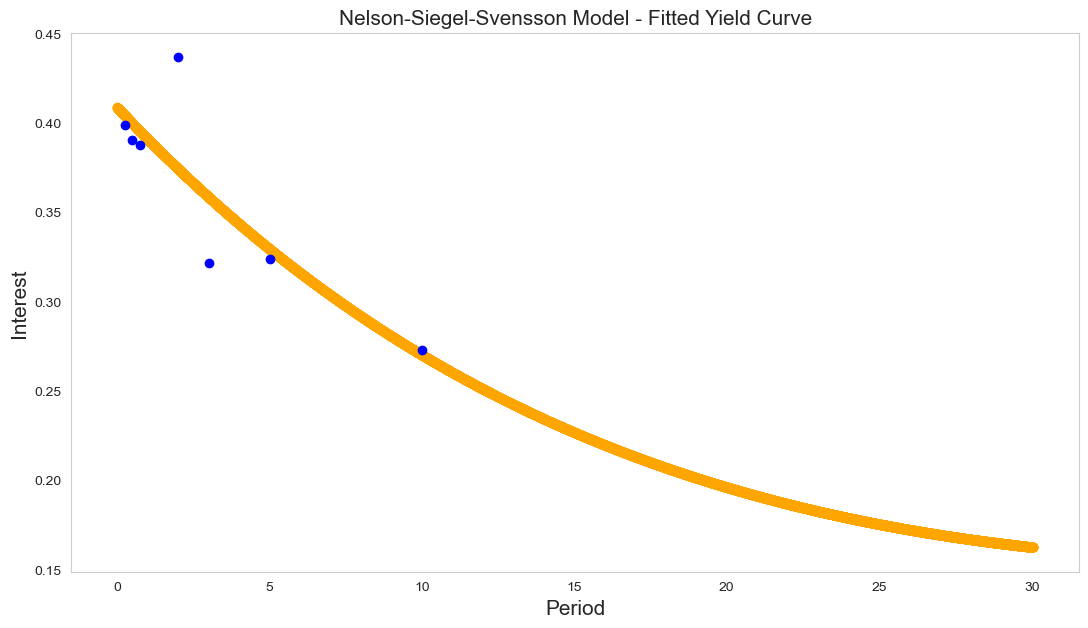

In [461]:
df = dd.copy()
df['NSS'] =(β0)+(β1*((1-np.exp(-df['Maturity']/λ0))/(df['Maturity']/λ0)))+(β2*((((1-np.exp(-df['Maturity']/λ0))/(df['Maturity']/λ0)))-(np.exp(-df['Maturity']/λ0))))+(β3*((((1-np.exp(-df['Maturity']/λ1))/(df['Maturity']/λ1)))-(np.exp(-df['Maturity']/λ1))))
fontsize=15
plt.figure(figsize=(13,7))
plt.scatter(df['Maturity'], df['NSS'], color="orange", label="NSS")
plt.scatter(dd['Maturity'], dd['Yield'], marker="o", c="blue")
plt.xlabel('Period',fontsize=fontsize)
plt.ylabel('Interest',fontsize=fontsize)
plt.title("Nelson-Siegel-Svensson Model - Fitted Yield Curve",fontsize=fontsize)
plt.grid()
plt.show()

#### Calculating discount factors

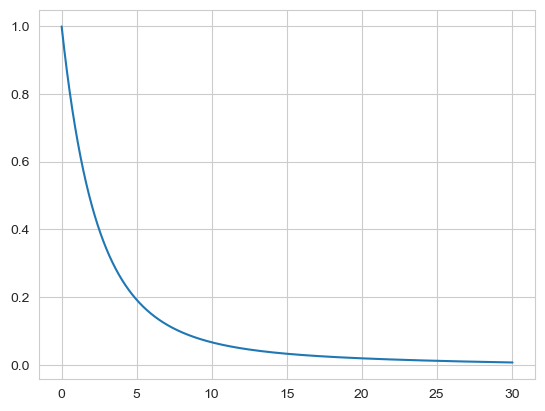

In [462]:
df['Discount'] = np.exp(-df['NSS'] * df['Maturity'])
plt.plot(df["Maturity"], df['Discount'])
None

#### Calculating instantenious forward rates

In [463]:
df['Forward'] = -(1/(1/252)) * np.log(df['Discount'].shift(-1)/df['Discount'])

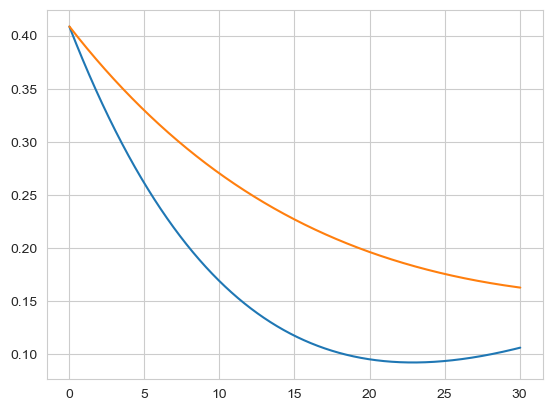

In [464]:
plt.plot(df["Maturity"], df['Forward'])
plt.plot(df["Maturity"], df['NSS'])
None

In [465]:
df['Forward Derivative'] = (df['Forward'].shift(-1) - df['Forward'])/(1/252)

df_old = pd.read_csv("turk3myield.csv")
df_old["Date"] =pd.to_datetime(df_old ["Date"])
df_old = df_old.sort_values(by='Date')
df_old = df_old.reset_index()

### Calculating necessary variables to simulate Vasicek

#sigma on full sample, as well as parameters for the model that predicts 365 in the future (using full sample)
sigma = np.std(df_old["Price"] * 0.01) * np.sqrt(252)
kappa = lamb
theta = lamb * mu

Hull-White:

$$
\mathrm{d}r(t) = (\theta(t)-\kappa r(t))\mathrm{d}t+\sigma\mathrm{d}W(t)
$$

Vasicek:

$$
\mathrm{d}r(t) = (\theta-\kappa r(t))\mathrm{d}t+\sigma\mathrm{d}W(t)
$$

### Calculating theta for the Hull-White Simulations

#### 1. For the future forecast (from the current day)

In [466]:
df['Theta'] = df['Forward Derivative'] + kappa * df['Forward'] + (sigma**2 / (2*kappa))*(1 - np.exp(-2*kappa * df["Maturity"]))
df['Theta']  = df['Theta'].interpolate(method='linear', limit_direction='both')

#### 2. For the in-sample simulations - we have to find the yield curve for the January of 2021

How can we do it? Simply find historical yields (closing) on Turkish treasutries (3,6,9-month, 2,3,5,10-year) at time 1st of January 2021 from the investing.com

In [467]:
termstruc = pd.DataFrame()
termstruc['Maturity'] = [3/12, 6/12, 9/12, 2, 3, 5, 10]
termstruc['Yield'] = np.array([14.227, 14.766, 15.289, 14.25, 13.64, 12.93, 12.57])*0.01

β0 = 0.01
β1 = 0.01
β2 = 0.01
β3 = 0.01
λ0 = 1.00
λ1 = 1.00

b = pd.DataFrame({"Maturity": np.arange(0,10.05,(1/252))})
df1 = pd.merge(left = b, right = termstruc, how = "left", on = "Maturity")
dd = df1.copy()
df1['NSS'] = (β0)+(β1*((1-np.exp(-df['Maturity']/λ0))/(df['Maturity']/λ0)))+(β2*((((1-np.exp(-df1['Maturity']/λ0))/(df1['Maturity']/λ0)))-(np.exp(-df1['Maturity']/λ0))))+(β3*((((1-np.exp(-df1['Maturity']/λ1))/(df1['Maturity']/λ1)))-(np.exp(-df1['Maturity']/λ1))))
df1['Residual'] =  (df1['Yield'] - df1['NSS'])**2

In [468]:
def myval(c):
    df1 = dd.copy()
    df1['NSS'] =(c[0])+(c[1]*((1-np.exp(-df1['Maturity']/c[4]))/(df1['Maturity']/c[4])))+(c[2]*((((1-np.exp(-df1['Maturity']/c[4]))/(df1['Maturity']/c[4])))-(np.exp(-df1['Maturity']/c[4]))))+(c[3]*((((1-np.exp(-df1['Maturity']/c[5]))/(df1['Maturity']/c[5])))-(np.exp(-df1['Maturity']/c[5]))))
    df1['Residual'] =  (df1['Yield'] - df1['NSS'])**2
    val = np.sum(df1['Residual'])
    print("[β0, β1, β2, β3, λ0, λ1]=",c,", SUM:", val)
    return(val)

c = fmin(myval, [0.1, 0.1, 0.1, 0.1, 1.00, 1.00])

[β0, β1, β2, β3, λ0, λ1]= [0.1 0.1 0.1 0.1 1.  1. ] , SUM: 0.019945375342425936
[β0, β1, β2, β3, λ0, λ1]= [0.105 0.1   0.1   0.1   1.    1.   ] , SUM: 0.0235228620068113
[β0, β1, β2, β3, λ0, λ1]= [0.1   0.105 0.1   0.1   1.    1.   ] , SUM: 0.022049780937584616
[β0, β1, β2, β3, λ0, λ1]= [0.1   0.1   0.105 0.1   1.    1.   ] , SUM: 0.020661055381021434
[β0, β1, β2, β3, λ0, λ1]= [0.1   0.1   0.1   0.105 1.    1.   ] , SUM: 0.020661055381021434
[β0, β1, β2, β3, λ0, λ1]= [0.1  0.1  0.1  0.1  1.05 1.  ] , SUM: 0.02054447222358011
[β0, β1, β2, β3, λ0, λ1]= [0.1  0.1  0.1  0.1  1.   1.05] , SUM: 0.019847754581709134
[β0, β1, β2, β3, λ0, λ1]= [0.095      0.10166667 0.10166667 0.10166667 1.01666667 1.01666667] , SUM: 0.017940343202048997
[β0, β1, β2, β3, λ0, λ1]= [0.09   0.1025 0.1025 0.1025 1.025  1.025 ] , SUM: 0.015500234112579484
[β0, β1, β2, β3, λ0, λ1]= [0.09666667 0.09583333 0.1025     0.1025     1.025      1.025     ] , SUM: 0.017040422080642787
[β0, β1, β2, β3, λ0, λ1]= [0.09555556 0.0

C:\Users\dguse\AppData\Roaming\Python\Python39\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp


[β0, β1, β2, β3, λ0, λ1]= [ 0.11959148 -0.0163041   0.10406763  0.07128884 -0.00411286  2.31906058] , SUM: inf
[β0, β1, β2, β3, λ0, λ1]= [0.11551752 0.00500281 0.10036661 0.08273655 0.16730521 2.05947566] , SUM: 0.0004781142993574793
[β0, β1, β2, β3, λ0, λ1]= [0.08985812 0.03493712 0.10416779 0.09301939 0.48039187 1.78251038] , SUM: 0.00020454788372314988
[β0, β1, β2, β3, λ0, λ1]= [0.08480904 0.03796914 0.10689971 0.09159893 0.46154032 1.78291545] , SUM: 0.0003874216612841604
[β0, β1, β2, β3, λ0, λ1]= [0.10105823 0.02276425 0.10188862 0.08960722 0.36887549 1.88624578] , SUM: 0.00016110748464347787
[β0, β1, β2, β3, λ0, λ1]= [0.11068788 0.01221883 0.09772789 0.08515287 0.29729189 1.99690697] , SUM: 0.00041042304044040004
[β0, β1, β2, β3, λ0, λ1]= [0.09195552 0.03176152 0.105068   0.09174609 0.42599467 1.81291528] , SUM: 0.0001571333882001791
[β0, β1, β2, β3, λ0, λ1]= [0.1032861  0.01269874 0.10086058 0.09378143 0.28228173 1.98623935] , SUM: 9.429521894119486e-05
[β0, β1, β2, β3, λ0, λ1]=

[β0, β1, β2, β3, λ0, λ1]= [0.10227042 0.01382637 0.1048971  0.0825625  0.29287634 1.98581609] , SUM: 4.977929291135119e-05
[β0, β1, β2, β3, λ0, λ1]= [0.10335126 0.0128678  0.10490427 0.08087201 0.28219225 1.99643236] , SUM: 4.901551858552564e-05
[β0, β1, β2, β3, λ0, λ1]= [0.103297   0.01272467 0.10550228 0.07960386 0.27660853 2.00547929] , SUM: 5.101203805995296e-05
[β0, β1, β2, β3, λ0, λ1]= [0.10275732 0.0133597  0.1059402  0.07870317 0.29263274 1.98981003] , SUM: 4.777285968628512e-05
[β0, β1, β2, β3, λ0, λ1]= [0.10186053 0.01464118 0.10483876 0.08293189 0.31056115 1.96577158] , SUM: 4.912767241991845e-05
[β0, β1, β2, β3, λ0, λ1]= [0.10255795 0.0143355  0.1050479  0.08050083 0.30616146 1.97366683] , SUM: 4.619921060323145e-05
[β0, β1, β2, β3, λ0, λ1]= [0.10414484 0.01154241 0.10548176 0.07826259 0.28087222 2.00288797] , SUM: 4.674823965555145e-05
[β0, β1, β2, β3, λ0, λ1]= [0.10375966 0.01270821 0.10560079 0.07776505 0.29579914 1.98648655] , SUM: 4.394215416355013e-05
[β0, β1, β2, β3,

[β0, β1, β2, β3, λ0, λ1]= [ 0.1177422  -0.0067321   0.12127196  0.01212239  0.37510832  2.01628451] , SUM: 1.6609238770633053e-05
[β0, β1, β2, β3, λ0, λ1]= [ 0.11674462 -0.00522911  0.12160207  0.01208229  0.38434018  2.0038051 ] , SUM: 2.0446215268826135e-05
[β0, β1, β2, β3, λ0, λ1]= [ 0.11597693 -0.00424679  0.11856151  0.022978    0.36124035  2.0107923 ] , SUM: 1.573943815828659e-05
[β0, β1, β2, β3, λ0, λ1]= [ 0.11803271 -0.00747094  0.12117114  0.01325786  0.3537871   2.0331417 ] , SUM: 1.7499974006053478e-05
[β0, β1, β2, β3, λ0, λ1]= [ 0.11562238 -0.00360761  0.11888621  0.02192966  0.37223193  2.00118791] , SUM: 1.588830142215451e-05
[β0, β1, β2, β3, λ0, λ1]= [ 0.11440284 -0.00201718  0.1172285   0.02922481  0.3561002   2.00236164] , SUM: 1.6538097684541286e-05
[β0, β1, β2, β3, λ0, λ1]= [ 1.13059543e-01 -1.45168300e-03  1.14978307e-01  3.84914264e-02
  3.33668786e-01  2.01642048e+00] , SUM: 1.8597394177117597e-05
[β0, β1, β2, β3, λ0, λ1]= [ 0.11670101 -0.00484604  0.12020613  0.0

[β0, β1, β2, β3, λ0, λ1]= [ 0.11730616 -0.00538123  0.11993576  0.0156759   0.37417434  2.00930295] , SUM: 1.5276367033529326e-05
[β0, β1, β2, β3, λ0, λ1]= [ 0.11692542 -0.00482495  0.11944401  0.01741648  0.37151617  2.01058583] , SUM: 1.5242685565070514e-05
[β0, β1, β2, β3, λ0, λ1]= [ 0.11726661 -0.00529962  0.1198163   0.0157851   0.37399251  2.01108761] , SUM: 1.520227273658473e-05
[β0, β1, β2, β3, λ0, λ1]= [ 0.11727676 -0.00519578  0.11967407  0.01598217  0.37472919  2.01026961] , SUM: 1.520932690505906e-05
[β0, β1, β2, β3, λ0, λ1]= [ 0.11704286 -0.00477941  0.1194593   0.01663472  0.37597296  2.00886725] , SUM: 1.5182117743197971e-05
[β0, β1, β2, β3, λ0, λ1]= [ 0.11686905 -0.00441891  0.11916911  0.01728978  0.37751069  2.00781797] , SUM: 1.5184713209391054e-05
[β0, β1, β2, β3, λ0, λ1]= [ 0.1170394  -0.00469798  0.11940439  0.01660302  0.37529566  2.01038489] , SUM: 1.5140778734101377e-05
[β0, β1, β2, β3, λ0, λ1]= [ 0.11690603 -0.00435636  0.11913871  0.01706658  0.37585632  2.01

[β0, β1, β2, β3, λ0, λ1]= [ 1.22545992e-01  1.00697913e-03  1.07191496e-01 -1.73136565e-02
  5.19605584e-01  2.15415078e+00] , SUM: 6.971361617192656e-06
[β0, β1, β2, β3, λ0, λ1]= [ 1.21312638e-01  1.36141971e-03  1.07466849e-01 -1.05439626e-02
  5.06485973e-01  2.13755316e+00] , SUM: 7.1303803514523714e-06
[β0, β1, β2, β3, λ0, λ1]= [ 1.23092099e-01 -5.76493308e-04  1.08249409e-01 -1.91730316e-02
  5.19265186e-01  2.15271052e+00] , SUM: 7.666845716582508e-06
[β0, β1, β2, β3, λ0, λ1]= [ 0.12168375  0.00326408  0.10461242 -0.01389081  0.5269155   2.1640666 ] , SUM: 6.838779279097966e-06
[β0, β1, β2, β3, λ0, λ1]= [ 1.24442692e-01  1.76936494e-03  1.04545200e-01 -2.80272600e-02
  5.63401822e-01  2.18881915e+00] , SUM: 7.2683329323087265e-06
[β0, β1, β2, β3, λ0, λ1]= [ 0.12134971  0.00229096  0.1059973  -0.011454    0.51264465  2.1520729 ] , SUM: 6.818005330763577e-06
[β0, β1, β2, β3, λ0, λ1]= [ 0.12346113  0.00318262  0.10306983 -0.02371623  0.55469434  2.19593005] , SUM: 7.599758451881895

[β0, β1, β2, β3, λ0, λ1]= [ 0.12156362  0.00411011  0.09964354 -0.01069111  0.52155271  2.2124541 ] , SUM: 5.643642522268376e-06
[β0, β1, β2, β3, λ0, λ1]= [ 0.12126819  0.00405302  0.09875693 -0.00790584  0.50977158  2.2201973 ] , SUM: 5.549588448206703e-06
[β0, β1, β2, β3, λ0, λ1]= [ 0.12112938  0.00423558  0.09779166 -0.00653079  0.50731564  2.22816439] , SUM: 5.6118676735845005e-06
[β0, β1, β2, β3, λ0, λ1]= [ 0.12204471  0.00381667  0.09991151 -0.01307762  0.52640177  2.21327072] , SUM: 5.584267289193364e-06
[β0, β1, β2, β3, λ0, λ1]= [ 0.12200609  0.00401217  0.0983406  -0.01199077  0.52298071  2.23039531] , SUM: 5.543047337613514e-06
[β0, β1, β2, β3, λ0, λ1]= [ 0.12240381  0.00413082  0.09718078 -0.01366029  0.52951938  2.24531525] , SUM: 5.6355617672673335e-06
[β0, β1, β2, β3, λ0, λ1]= [ 0.12180062  0.00364428  0.09892298 -0.01038461  0.51180737  2.22447706] , SUM: 5.493475694833534e-06
[β0, β1, β2, β3, λ0, λ1]= [ 0.12191912  0.00341136  0.0985627  -0.01023137  0.5069347   2.23048

[β0, β1, β2, β3, λ0, λ1]= [ 1.23991303e-01  1.55089600e-03  9.87231975e-02 -1.72243735e-02
  5.17007811e-01  2.23293355e+00] , SUM: 4.771510869215686e-06
[β0, β1, β2, β3, λ0, λ1]= [ 1.24124828e-01  1.67861645e-03  9.83113447e-02 -1.76985152e-02
  5.19005594e-01  2.23630818e+00] , SUM: 4.738179520147878e-06
[β0, β1, β2, β3, λ0, λ1]= [ 1.24371957e-01  1.27064089e-03  9.92386489e-02 -1.89827715e-02
  5.18866504e-01  2.22819488e+00] , SUM: 4.740263893871175e-06
[β0, β1, β2, β3, λ0, λ1]= [ 1.24204820e-01  1.74808728e-03  9.77843959e-02 -1.74588814e-02
  5.18756913e-01  2.23899382e+00] , SUM: 4.71885822430643e-06
[β0, β1, β2, β3, λ0, λ1]= [ 1.24145646e-01  1.82627615e-03  9.73521350e-02 -1.67015660e-02
  5.17445991e-01  2.24122030e+00] , SUM: 4.7564889092312e-06
[β0, β1, β2, β3, λ0, λ1]= [ 1.23926888e-01  1.50081921e-03  9.84396705e-02 -1.55968522e-02
  5.05819562e-01  2.23106011e+00] , SUM: 4.799420644502601e-06
[β0, β1, β2, β3, λ0, λ1]= [ 1.24358245e-01  1.73739607e-03  9.80659160e-02 -1.8

[β0, β1, β2, β3, λ0, λ1]= [ 1.24599863e-01  1.32792537e-03  9.88368714e-02 -1.98401020e-02
  5.25861113e-01  2.23048454e+00] , SUM: 4.686180262202208e-06
[β0, β1, β2, β3, λ0, λ1]= [ 1.24544306e-01  1.42907599e-03  9.87010134e-02 -1.96200627e-02
  5.25767009e-01  2.23149526e+00] , SUM: 4.685877165234012e-06
[β0, β1, β2, β3, λ0, λ1]= [ 1.24560684e-01  1.39620546e-03  9.88214075e-02 -1.97580677e-02
  5.26000957e-01  2.23042865e+00] , SUM: 4.6861902577335685e-06
[β0, β1, β2, β3, λ0, λ1]= [ 1.24560022e-01  1.40141655e-03  9.87143370e-02 -1.96594509e-02
  5.25729189e-01  2.23144956e+00] , SUM: 4.685867556154907e-06
[β0, β1, β2, β3, λ0, λ1]= [ 1.24542023e-01  1.43927240e-03  9.86726848e-02 -1.95818795e-02
  5.25762082e-01  2.23154792e+00] , SUM: 4.685950566911593e-06
[β0, β1, β2, β3, λ0, λ1]= [ 1.24539630e-01  1.41292452e-03  9.86808112e-02 -1.95170942e-02
  5.25149096e-01  2.23158450e+00] , SUM: 4.685991976467637e-06
[β0, β1, β2, β3, λ0, λ1]= [ 1.24560675e-01  1.40877614e-03  9.87412603e-02 

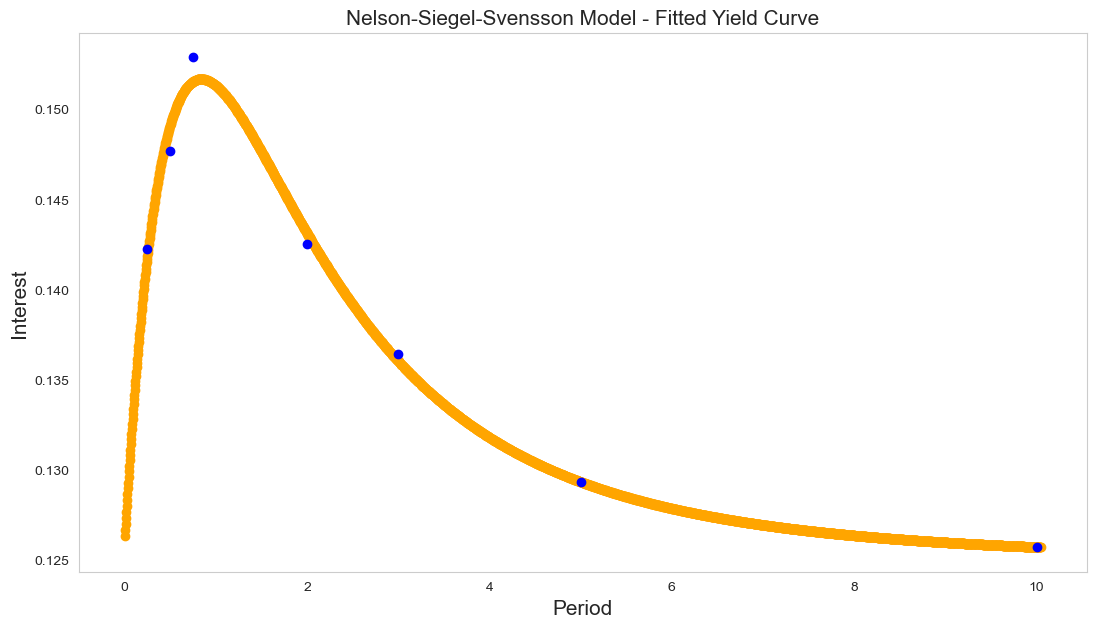

In [469]:
df1 = dd.copy()
β0 = c[0]
β1 = c[1]
β2 = c[2]
β3 = c[3]
λ0 = c[4]
λ1 = c[5]

df1['NSS'] =(β0)+(β1*((1-np.exp(-df1['Maturity']/λ0))/(df1['Maturity']/λ0)))+(β2*((((1-np.exp(-df1['Maturity']/λ0))/(df1['Maturity']/λ0)))-(np.exp(-df1['Maturity']/λ0))))+(β3*((((1-np.exp(-df1['Maturity']/λ1))/(df1['Maturity']/λ1)))-(np.exp(-df1['Maturity']/λ1))))
fontsize=15
plt.figure(figsize=(13,7))
plt.scatter(df1['Maturity'], df1['NSS'], color="orange", label="NSS")
plt.scatter(dd['Maturity'], dd['Yield'], marker="o", c="blue")
plt.xlabel('Period',fontsize=fontsize)
plt.ylabel('Interest',fontsize=fontsize)
plt.title("Nelson-Siegel-Svensson Model - Fitted Yield Curve",fontsize=fontsize)
plt.grid()
plt.show()

In [470]:
df1['Discount'] = np.exp(-df1['NSS'] * df1['Maturity'])
df1['Forward'] = -(1/(1/252)) * np.log(df1['Discount'].shift(-1)/df1['Discount'])

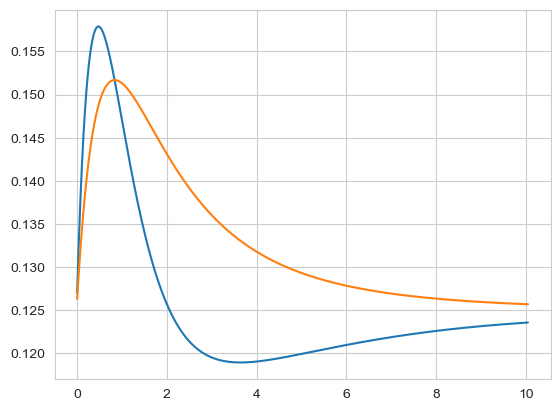

In [471]:
### Plotting forward and spot rates
plt.plot(df1["Maturity"], df1['Forward'])
plt.plot(df1["Maturity"], df1['NSS'])
None

In [472]:
df1['Forward Derivative'] = (df1['Forward'].shift(-1) - df1['Forward'])/(1/252)
kappa = lamb_test
### sigma on train
sigma = np.std(df_old["Price"].iloc[:4000] * 0.01) * np.sqrt(252)
df1['Theta'] = df1['Forward Derivative'] + kappa * df1['Forward'] + (sigma**2 / (2*kappa))*(1 - np.exp(-2*kappa * df1["Maturity"]))
df1['Theta']  = df1['Theta'].interpolate(method='linear', limit_direction='both')

## Vasicek Simulation (Backtest)

### We simulate in 1000 observations in the past. Namely, from the beginning of 2021 to the beginning of 2024

In [473]:
def vasicek(r0, kappa, theta, sigma, T, dt, n_paths):
    """
    Simulate interest rates using the Vasicek model.

    Parameters:
        r0 (float): Initial interest rate.
        kappa (float): Mean-reversion rate.
        theta (float): Long-term mean of the interest rate.
        sigma (float): Volatility of the interest rate.
        T (float): Time horizon.
        dt (float): Time step size.
        n_paths (int): Number of simulation paths.

    Returns:
        numpy.ndarray: Simulated interest rate paths.
    """
    np.random.seed(1337)
    n_steps = int(T / dt)
    rates = np.zeros((n_paths, n_steps))
    rates[:, 0] = r0

    for i in range(1, n_steps):
        dW = np.random.normal(0, np.sqrt(dt), size=n_paths)
        rates[:, i] = rates[:, i - 1] + kappa * (theta -  rates[:, i - 1]) * dt + sigma * np.sqrt(dt) * dW

    return rates

In [474]:
train_size = int(0.8 * len(df_old))
train_df = df_old[:train_size]
test_df = df_old[train_size:]
train_y = train_df['Price'] * 0.01
test_y = test_df['Price'] * 0.01

In [475]:
lamb_test

1.0763156585259765

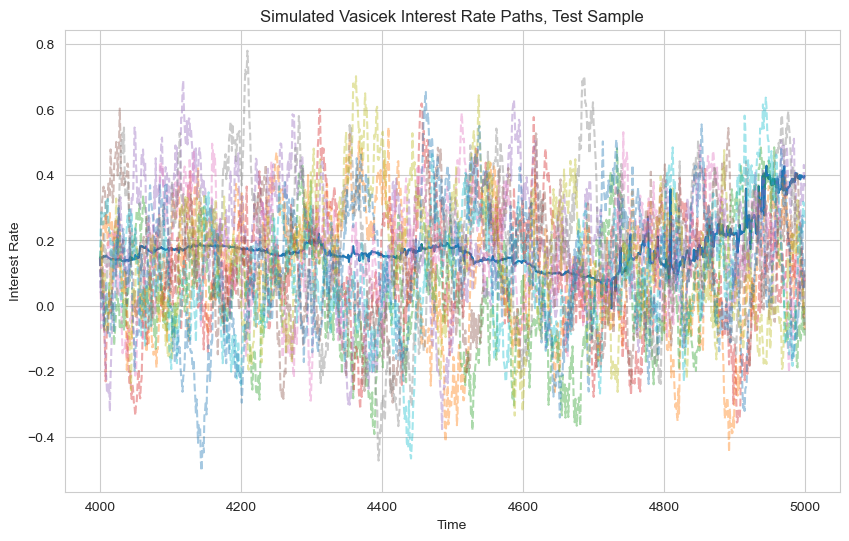

In [476]:
# Parameters
r0 = train_y.iloc[-1]  # Initial interest rate
kappa = lamb  # Mean-reversion rate
theta = lamb * mu  # Long-term mean of the interest rate
sigma = np.std(df_old["Price"].iloc[:4000] * 0.01) * np.sqrt(252)  # Volatility of the interest rate
T = 50  # Time horizon
dt = 0.05 # Time step size (daily steps)
n_paths = 10  # Number of simulation paths

# Simulate interest rates
interest_rates = vasicek(r0, lamb_test, mu_test, sigma, T, dt, n_paths)

# Plot simulation results
plt.figure(figsize=(10, 6))
#plt.plot(train_df.index,train_y, label='Past Rates')
plt.plot(test_df.index,test_y, label='Actual Rates')
plt.plot(test_df.index, interest_rates.T, linestyle='--', alpha = 0.4)
plt.title('Simulated Vasicek Interest Rate Paths, Test Sample')
plt.xlabel('Time')
plt.ylabel('Interest Rate')
plt.grid(True)
plt.show()

### Calculating RMSE on test sample

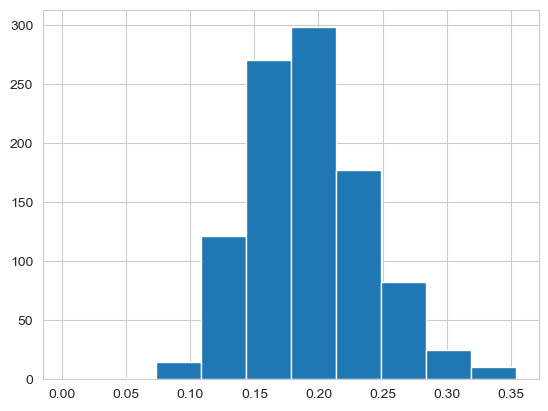

In [477]:
squared_diff = (np.tile(test_y, (10, 1)) - interest_rates)**2
mean_squared_diff = np.mean(squared_diff, axis=0)
rmse = np.sqrt(mean_squared_diff)
plt.hist(rmse)
None

## Hull-White Simulation (Backtest)

### We simulate in 1000 observations in the past. Namely, from the beginning of 2021 to the beginning of 2024

In [478]:
def hullwhite(r0, kappa, theta, sigma, T, dt, n_paths):
    """
    Simulate interest rates using the Vasicek model.

    Parameters:
        r0 (float): Initial interest rate.
        kappa (float): Mean-reversion rate.
        theta (array): Long-term mean of the interest rate.
        sigma (float): Volatility of the interest rate.
        T (float): Time horizon.
        dt (float): Time step size.
        n_paths (int): Number of simulation paths.

    Returns:
        numpy.ndarray: Simulated interest rate paths.
    """
    np.random.seed(1337)
    n_steps = int(T / dt)
    rates = np.zeros((n_paths, n_steps))
    rates[:, 0] = r0

    for i in range(1, n_steps):
        dW = np.random.normal(0, np.sqrt(dt), size=n_paths)
        rates[:, i] = rates[:, i - 1] + (theta[i-1] - kappa * rates[:, i - 1]) * dt + sigma * np.sqrt(dt) * dW

    return rates

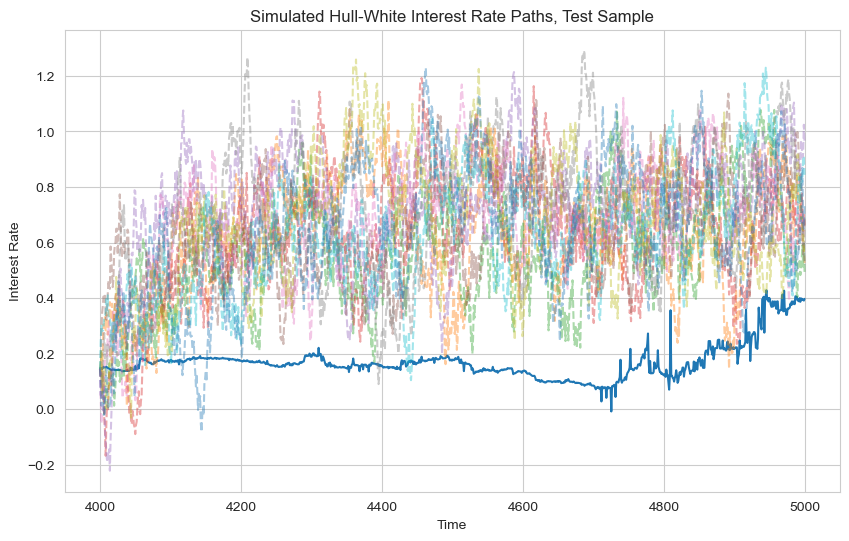

In [479]:
# Parameters
r0 = train_y.iloc[-1]  # Initial interest rate
kappa = lamb_test  # Mean-reversion rate
theta_array = df1['Theta'].values  # Example array for theta
sigma = np.std(df_old["Price"].iloc[:4000] * 0.01) * np.sqrt(252) # Volatility of the interest rate
T = 50  # Time at which to simulate the interest rate
dt = 0.05  # Time step size
n_paths = 10
# Simulate interest rate
interest_rate = hullwhite(r0, kappa, theta_array, sigma, T, dt, n_paths)

# Plot simulation results
plt.figure(figsize=(10, 6))
#plt.plot(train_df.index,train_y, label='Past Rates')
plt.plot(test_df.index,test_y, label='Actual Rates')
plt.plot(test_df.index, interest_rate.T, linestyle='--', alpha = 0.4)
plt.title('Simulated Hull-White Interest Rate Paths, Test Sample')
plt.xlabel('Time')
plt.ylabel('Interest Rate')
plt.grid(True)
plt.show()

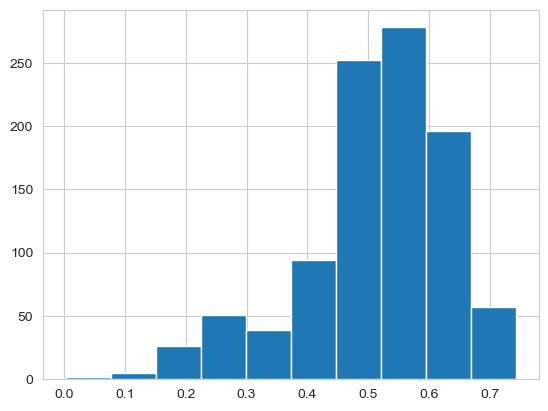

In [480]:
squared_diff = (np.tile(test_y, (10, 1)) - interest_rate)**2
mean_squared_diff = np.mean(squared_diff, axis=0)
rmse = np.sqrt(mean_squared_diff)
plt.hist(rmse)
None

# Out-of sample simulations for both models

C:\Users\dguse\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\dguse\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\dguse\anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


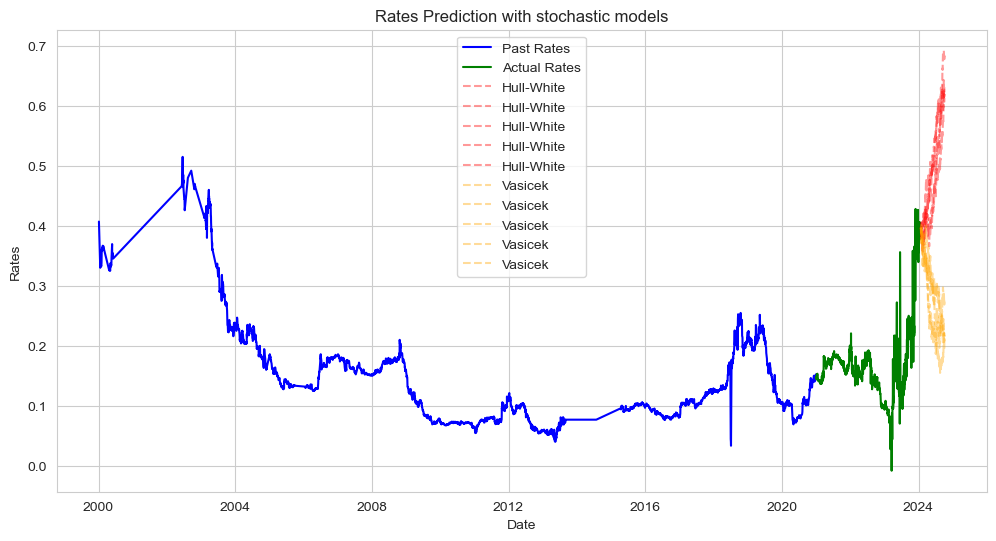

In [481]:
r0 = test_y.iloc[-1]
kappa = lamb
theta = mu
theta_array = df['Theta'].values
sigma = np.std(df_old["Price"] * 0.01) * np.sqrt(252)
T = 1
dt = 1/252
n_paths = 5

forecast_steps = 252
future_indices = range(len(test_df), len(test_df) + forecast_steps)
future_predictions = ar_results.predict(start=len(train_df), end=len(train_df) + len(test_df) + forecast_steps - 1, dynamic=True)
future_dates = pd.date_range(start=test_df['Date'].iloc[-1], periods=forecast_steps, freq='D')

interest_rate = hullwhite(r0, kappa, theta_array, sigma, T, dt, n_paths)
interest_rates = vasicek(r0, kappa, theta, sigma, T, dt, n_paths)

plt.figure(figsize=(12, 6))
plt.plot(train_df['Date'],train_y, label='Past Rates', color = "blue")
plt.plot(test_df['Date'],test_y, label='Actual Rates', color = "green")
plt.plot(future_dates, interest_rate.T, linestyle='--', alpha = 0.4, color = "red", label = "Hull-White")
plt.plot(future_dates, interest_rates.T, linestyle='--', alpha = 0.4, color = "orange", label = "Vasicek")
plt.xlabel('Date')
plt.ylabel('Rates')
plt.legend()
plt.title('Rates Prediction with stochastic models')
plt.show()

# Stage 3. IR Modelling - Turkey 3-month Bond Yield

As the Vasicek model gave the best RMSE on the test sample, it is safe to assume that the forecast using this model will be the most reliable out of all the options: AR, Hull-White, Vasicek. 

As the model implies mean-reversion and current interest rates are unreasonably high, it is expected that contractionary monetary policy will take place or simply the uncertainty in the economy will decrease. 

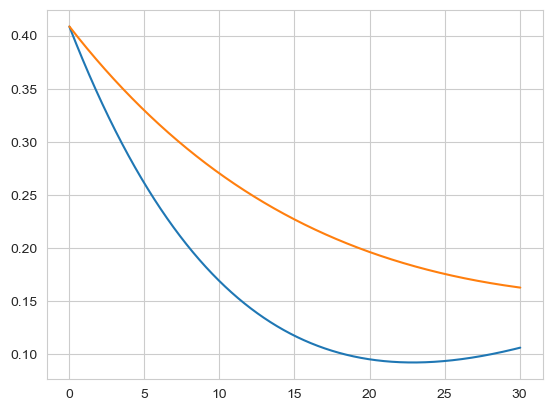

In [482]:
plt.plot(df["Maturity"], df['Forward'])
plt.plot(df["Maturity"], df['NSS'])
None

Currently the yield curve is significantly inverse and in addition forward rates are even lower (due to negative slope of the yield curve - derived from the formula)